
#### This notebook compared several different sentiment classification algorithm on the book "Stop asking how was your day".

###### Models include:
1. Rader - a rule-based model using lexicon
2. Hugging Face fine tuned LLMs for sentiment analysis

# Learnings:
1. Most questions in the book have a "neutral" sentiment, which make sense. These questions should provide an opportunity to start an undirected conversation.
2. Machine learning models tend to be more sentimental than rule based model, which classify more "positive" and "negative" sentiments.
3. difference between the machine learning models depends on algorithm and fine-tuned data(common sense).


In [1]:
import os
import numpy as np
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline
import matplotlib.pyplot as plt 
from scipy.stats import entropy

In [2]:
# load data
df_questions = pd.read_csv('data_how_was_your_day.csv', encoding='cp1252')

In [3]:
# sentiment analysis using Rader
sentim_analyzer = SentimentIntensityAnalyzer()
sentim_analyzer.polarity_scores('Do you know that its okay if youre not perfect?')
df_questions['Rader_results']=df_questions['Questions'].apply(lambda x:sentim_analyzer.polarity_scores(x))
df_questions['label_Rader']=df_questions['Rader_results'].apply(lambda x:max((k for k in x if k!='compound'), key=x.get))

In [4]:
# sentiment analysis using hugging face ML models
HF_Model_List=["mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
               ,"finiteautomata/bertweet-base-sentiment-analysis"
               ,"cardiffnlp/twitter-roberta-base-sentiment-latest"]
for model in HF_Model_List:
    classifier=pipeline("sentiment-analysis",model=model)
    df_questions['label_'+model]=df_questions['Questions'].apply(lambda x:classifier(x)[0].get('label'))

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
# replace label
df_questions['label_Rader']=df_questions['label_Rader'].replace({'neg':'negative','neu':'neutral','pos':'positive'})
df_questions['label_finiteautomata/bertweet-base-sentiment-analysis']=df_questions['label_finiteautomata/bertweet-base-sentiment-analysis'].replace({'NEG':'negative','NEU':'neutral','POS':'positive'})

In [6]:
label_columns = [col for col in df_questions.columns if col.startswith('label')]
label_value_counts = {col: df_questions[col].value_counts() for col in df_questions[label_columns]}
frequency_df = pd.DataFrame(label_value_counts).fillna(0)

<Axes: >

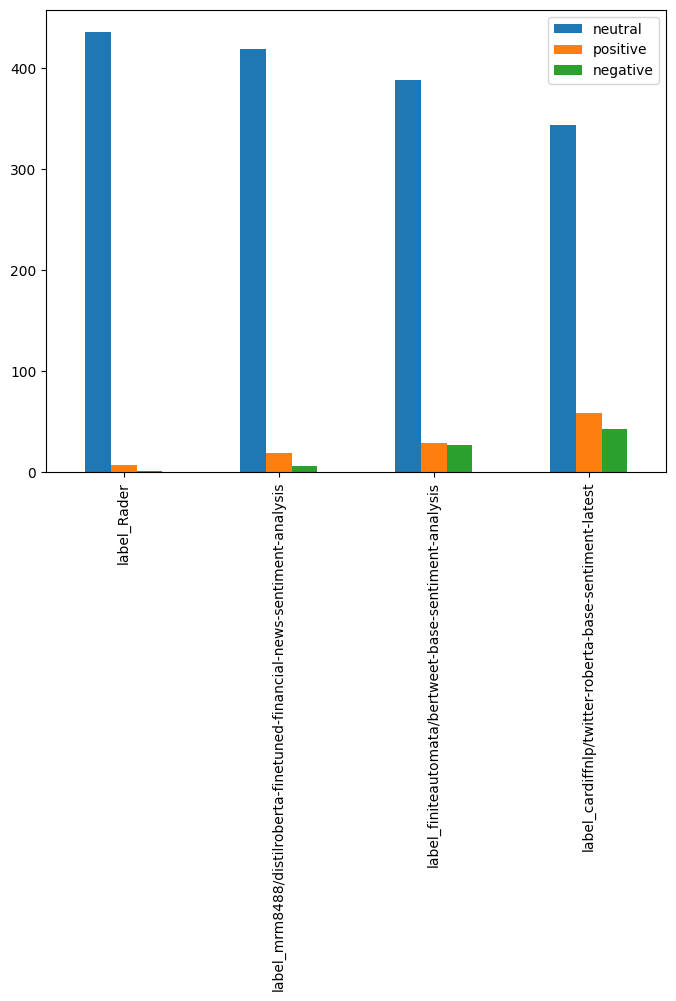

In [7]:
frequency_df.T.plot(kind='bar', figsize=(8, 6))

#### The results showed that machine learning models are more sentimental than Vader. And fine tuned model using twitter data is more sentimantal than using financial news data. 

In [8]:
# spot check on disagreement among different models
# here I use entropy to evaluate the degree of disagreement among models
def calculate_entropy(row):
    value,counts=np.unique(row, return_counts=True)
    # Calculate entropy
    return entropy(counts)
df_row_entropy=df_questions[label_columns].apply(lambda x:calculate_entropy(x),axis=1).sort_values(ascending=False)

#### Due to the concern regarding copyright, I'm not showing any questions in the book. Below I showed the results of several questions that I got inspired by the book. My understanding is that machine learning models has the advantage of fine-tuning using different data to adjust the level sensitivity and align the sentiment on different topics.

In [9]:
pd.set_option('display.max_colwidth', None)
sample_questions=pd.DataFrame(['How can you tell if someone is having a bad time?'
                              ,'What is the activity that can make every students excited at school?'
                              ,'How do you feel when other people are treated unfairly?'
                              ,'What is something in your school that you can make it better?'],columns=['Questions'])

sample_questions['Rader_results']=sample_questions['Questions'].apply(lambda x:sentim_analyzer.polarity_scores(x))
sample_questions['label_Rader']=sample_questions['Rader_results'].apply(lambda x:max((k for k in x if k!='compound'), key=x.get))
for model in HF_Model_List:
    classifier=pipeline("sentiment-analysis",model=model)
    sample_questions['label_'+model]=sample_questions['Questions'].apply(lambda x:classifier(x)[0].get('label'))

sample_questions['label_Rader']=sample_questions['label_Rader'].replace({'neg':'negative','neu':'neutral','pos':'positive'})
sample_questions['label_finiteautomata/bertweet-base-sentiment-analysis']=sample_questions['label_finiteautomata/bertweet-base-sentiment-analysis'].replace({'NEG':'negative','NEU':'neutral','POS':'positive'})
sample_questions.drop(columns=['Rader_results'])

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,Questions,label_Rader,label_mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis,label_finiteautomata/bertweet-base-sentiment-analysis,label_cardiffnlp/twitter-roberta-base-sentiment-latest
0,How can you tell if someone is having a bad time?,neutral,negative,negative,negative
1,What is the activity that can make every students excited at school?,neutral,neutral,positive,positive
2,How do you feel when other people are treated unfairly?,neutral,neutral,negative,negative
3,What is something in your school that you can make it better?,neutral,neutral,neutral,positive


In [10]:
# sentiment analysis using hugging face ML models
df_questions_emotion= pd.read_csv('data_how_was_your_day.csv', encoding='cp1252')
Emotion_Model_List=["michellejieli/emotion_text_classifier"
                   ,"j-hartmann/emotion-english-distilroberta-base"]

for model in Emotion_Model_List:
    classifier=pipeline("sentiment-analysis",model=model)
    df_questions_emotion['label_'+model]=df_questions_emotion['Questions'].apply(lambda x:classifier(x)[0].get('label'))

In [11]:
label_columns = [col for col in df_questions_emotion.columns if col.startswith('label')]
label_value_counts = {col: df_questions_emotion[col].value_counts() for col in df_questions_emotion[label_columns]}
frequency_df = pd.DataFrame(label_value_counts).fillna(0)

<Axes: >

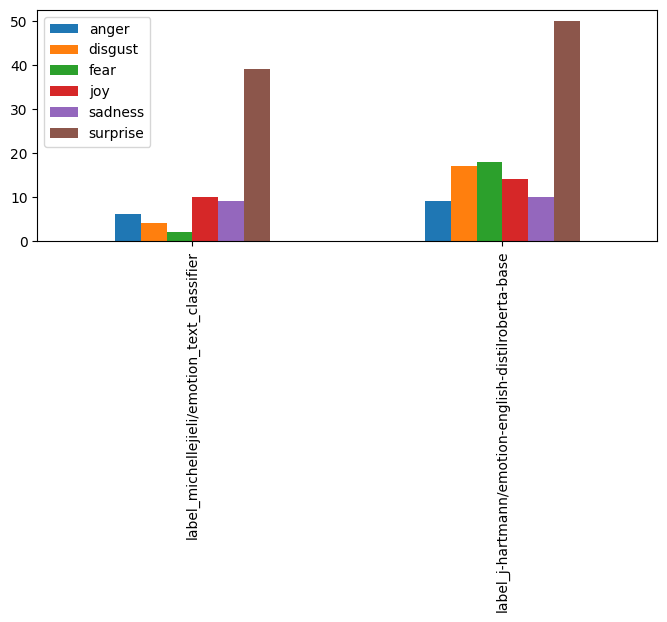

In [13]:
frequency_df[frequency_df.index!='neutral'].T.plot(kind='bar', figsize=(8, 3))

####  Not suprised to see "suprise" as highest among six basic emotions. These questions try to ask things you won't natually think about.